In [344]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [345]:
#!pip install torchvision == 11.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ql5vy0da/pytorch_3d7f6601c3354cba8af221cb39622acb/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ql5vy0da/pytorch_3d7f6601c3354cba8af221cb39622acb/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-7m_4pmud/install-record.txt --single-version-externally-managed --compile --install-headers /usr/

In [346]:
import torch

from torchvision import datasets, transforms
from torch.utils.data import Subset

In [347]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.utils import shuffle
from glob import glob
from sklearn.model_selection import train_test_split

In [348]:

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from IPython.display import clear_output
import itertools
import numpy.ma as ma
from threading import Thread
from torch.utils.data.dataset import random_split


In [349]:
import os
import cv2
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [350]:
# dirs
WORKING_DIR = '/content/drive/MyDrive/CS6501_DP/Project/'
INPUT_DIR = '/content/drive/MyDrive/CS6501_DP/Project/input/'
# WORKING_DIR = '/content/drive/MyDrive/Third Year/Data Privacy/Project'
# INPUT_DIR = '/content/drive/MyDrive/Third Year/Data Privacy/Project/input'

# classes
imgClasses = ['Cardiomegaly', 'Emphysema', 'Effusion', 
              'Hernia', 'Infiltration', 'Mass', 'Nodule', 
              'Atelectasis','Pneumothorax','Pleural_Thickening', 
              'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation',
              'No Finding']

In [351]:
# import data
os.chdir(INPUT_DIR)
all_xray_df = pd.read_csv('sample_labels.csv')

# obtain path to each image and add to dataframe
# use glob module to intelligently parse all files
# add to dictionary with key as filename
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data', 'images', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Rows', all_xray_df.shape[0])

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)



# this is multi-task, multi-class classification
# rename null finding
# split the string description 
all_xray_df['Finding Labels']  = all_xray_df['Finding Labels'].replace('No Finding', '')
#all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = list({x for l in all_xray_df['Finding Labels'].str.split('|') for x in l})

# obtain list of unique diseases
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

#perform one-hot encoding based on diseases extracted
for c_label in all_labels:
    if len(c_label)> 1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

# drop unused columns
all_xray_df = all_xray_df.drop(['OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y',
                               'Finding Labels',
                               'Follow-up #',
                               'OriginalImageWidth','OriginalImageHeight'
                               ], axis=1)


Scans found: 5606 , Total Rows 5606
All Labels (14): ['Fibrosis', 'Pneumothorax', 'Edema', 'Pneumonia', 'Hernia', 'Mass', 'Atelectasis', 'Nodule', 'Pleural_Thickening', 'Cardiomegaly', 'Effusion', 'Emphysema', 'Consolidation', 'Infiltration']


In [352]:
all_xray_df_sel = all_xray_df[['Image Index', 'Fibrosis', 'Pneumothorax', 'Atelectasis',
       'Infiltration', 'Nodule', 'Pneumonia', 'Consolidation', 'Hernia',
       'Emphysema', 'Pleural_Thickening', 'Effusion', 'Edema', 'Cardiomegaly',
       'Mass']]

In [353]:
from sklearn.preprocessing import LabelEncoder

In [354]:
ls_codes = list()
ls_save = list()
for i in range(len(all_xray_df_sel)):
  for disease_name in [ 'Fibrosis', 'Pneumothorax', 'Atelectasis', 'Infiltration', 'Nodule', 'Pneumonia', 'Consolidation', 'Hernia', 'Emphysema', 'Pleural_Thickening', 'Effusion', 'Edema', 'Cardiomegaly', 'Mass']:
    code_per = all_xray_df_sel.loc[i, disease_name]
    if code_per == 1:
      ls_save.append([all_xray_df_sel.loc[i, 'Image Index'], disease_name])
      # code_image = code_image + str(int(code_per))
  
#   ls_codes.append(code_image)
# all_xray_df_sel['Code'] = ls_codes
# all_xray_df_save = all_xray_df_sel[['Image Index', 'Code']]
all_xray_df_save = pd.DataFrame(ls_save, columns=['Image Index', 'Code'])
label_encode = LabelEncoder()
all_xray_df_save['Code'] = label_encode.fit_transform(all_xray_df_save['Code'])

In [355]:
os.chdir(INPUT_DIR)
all_xray_df_save.to_csv('sample_labels_reformat.csv', index=False)

In [356]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(all_xray_df_save, test_size=0.2)
train.to_csv('sample_labels_train.csv', index=False)
test.to_csv('sample_labels_test.csv', index=False)

In [357]:
train

,Image Index,Code
1502,00011925_010.png,8
2099,00015818_001.png,8
479,00004156_002.png,4
575,00004893_036.png,0
2065,00015606_006.png,3
...,...,...
3775,00029174_003.png,8
988,00008303_000.png,10
1460,00011731_006.png,8
377,00003186_005.png,8


In [358]:
# transformations
transformations = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.Resize((32,32)), 
                                      transforms.ToTensor(),
                                     transforms.Normalize([0.5], [0.5])])

os.chdir(INPUT_DIR)
image_dir = INPUT_DIR +'/data/images'
train_data = CustomImageDataset(annotations_file='sample_labels_train.csv', img_dir=image_dir, transform=transformations)
test_data = CustomImageDataset(annotations_file='sample_labels_test.csv', img_dir=image_dir, transform=transformations)

In [359]:
print('The shape of tensor for 50th image in train dataset: ',train_data[49][0].shape)

The shape of tensor for 50th image in train dataset:  torch.Size([3, 32, 32])


In [360]:

# training and test data info
print('num training data: {0}'.format(len(train_data)))
print('num test data: {0}'.format(len(test_data)))

num training data: 3147
num test data: 787


In [361]:


train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=True)


In [362]:
from torch.utils.data import Subset
num_teachers = 100

teacher_loaders = []  #list of dataloaders

# data_size = 35 # mnist_trainset/num_teachers
data_size = 30 # mnist_trainset/num_teachers

for i in range(num_teachers):
    
    indices = list(range(i*data_size, (i+1) *data_size)) #creating subsets of 600 data_size
    subset_data = Subset(train_data, indices)
    
    loader = torch.utils.data.DataLoader(subset_data, batch_size=50, num_workers=2)
    teacher_loaders.append(loader)

In [363]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Active device:", device)

Active device: cuda:0


In [364]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

images = images.numpy()

In [365]:

# # plot the images in the batch, along with the corresponding labels
# fig = plt.figure(figsize=(32, 4))
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#     ax.imshow(np.squeeze(images[idx]), cmap='gray')
#     # print out the correct label for each image.item() gets the value contained in a Tensor
#     ax.set_title(str(labels[idx].item()))

In [366]:
from torch import nn, optim
import torch.nn.functional as F

In [367]:

class Classifier(nn.Module):

    def __init__(self):
        super().__init__()
    
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(5*10*10, 50)
        self.fc2 = nn.Linear(50, 14)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), 5*10*10)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [368]:
epochs = 10
models = []
for i in range(num_teachers):
    model = Classifier()
    model.to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    running_loss = 0
    teacher_loss = []
    for e in range(epochs):
        running_loss = 0
        for images, labels in teacher_loaders[i]:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    teacher_loss.append(running_loss)
    
    print("Training teacher: {}/{}.. ".format(i+1, num_teachers), "Training Loss: {:.3f}.. ".format(running_loss))
    models.append(model)

<ipython-input-367-1095ff33de73>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Training teacher: 1/100..  Training Loss: 2.627.. 
Training teacher: 2/100..  Training Loss: 2.629.. 
Training teacher: 3/100..  Training Loss: 2.614.. 
Training teacher: 4/100..  Training Loss: 2.645.. 
Training teacher: 5/100..  Training Loss: 2.628.. 
Training teacher: 6/100..  Training Loss: 2.606.. 
Training teacher: 7/100..  Training Loss: 2.670.. 
Training teacher: 8/100..  Training Loss: 2.612.. 
Training teacher: 9/100..  Training Loss: 2.644.. 
Training teacher: 10/100..  Training Loss: 2.659.. 
Training teacher: 11/100..  Training Loss: 2.650.. 
Training teacher: 12/100..  Training Loss: 2.648.. 
Training teacher: 13/100..  Training Loss: 2.618.. 
Training teacher: 14/100..  Training Loss: 2.621.. 
Training teacher: 15/100..  Training Loss: 2.635.. 
Training teacher: 16/100..  Training Loss: 2.635.. 
Training teacher: 17/100..  Training Loss: 2.634.. 
Training teacher: 18/100..  Training Loss: 2.636.. 
Training teacher: 19/100..  Training Loss: 2.643.. 
Training teacher: 20/

In [369]:
#Creating the public dataset
student_traindata = Subset(test_data, list(range(600))) #90% of Test dat as train data
student_testdata = Subset(test_data, list(range(600, 787))) #10% of Test data as test data

In [370]:
#Creating student_loaders
student_trainloader = torch.utils.data.DataLoader(student_traindata, batch_size=50, shuffle=True)
student_testloader = torch.utils.data.DataLoader(student_testdata, batch_size=50, shuffle=True)

In [372]:
def perdict(model, dataloader):
    """
    Perdicts labels for a dataset
    Input: model and dataloader
    """
    outputs = torch.zeros(0, dtype=torch.long).to(device)
    model.to(device)
    model.eval()
    for image, labels in dataloader:
        image, labels = image.to(device), labels.to(device)  
        output = model(image)
        ps = torch.argmax(torch.exp(output), dim=1)
        outputs = torch.cat((outputs, ps))
    return outputs

In [374]:
# Creating the Aggregated Teacher and Student labels by combining the predictions of Teacher models
epsilon = 0.25
preds = torch.zeros((len(models),600), dtype=torch.long)
for i, model in enumerate(models):
    results = perdict(model, student_trainloader)
    preds[i] = results
labels = np.array([]).astype(int)
for image_preds in np.transpose(preds):  
    label_counts = np.bincount(image_preds, minlength = 10)
    beta = 1/ epsilon
    for i in range(len(label_counts)):
        label_counts[i] += np.random.laplace(0, beta, 1)
    new_label = np.argmax(label_counts)
    labels = np.append(labels, new_label)

<ipython-input-367-1095ff33de73>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [375]:
student_labels = np.array(labels)
preds = preds.numpy()

In [376]:
epochs = 50
train_losses, test_losses = [], []
model = Classifier()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
running_loss = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in student_trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in student_testloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))        
        train_losses.append(running_loss/len(student_trainloader))
        test_losses.append(test_loss/len(student_testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(student_trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(student_testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(student_testloader)))
    

<ipython-input-367-1095ff33de73>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch: 1/50..  Training Loss: 2.647..  Test Loss: 2.638..  Test Accuracy: 0.050
Epoch: 2/50..  Training Loss: 2.637..  Test Loss: 2.629..  Test Accuracy: 0.047
Epoch: 3/50..  Training Loss: 2.625..  Test Loss: 2.609..  Test Accuracy: 0.122
Epoch: 4/50..  Training Loss: 2.608..  Test Loss: 2.592..  Test Accuracy: 0.197
Epoch: 5/50..  Training Loss: 2.582..  Test Loss: 2.550..  Test Accuracy: 0.227
Epoch: 6/50..  Training Loss: 2.546..  Test Loss: 2.522..  Test Accuracy: 0.236
Epoch: 7/50..  Training Loss: 2.511..  Test Loss: 2.478..  Test Accuracy: 0.223
Epoch: 8/50..  Training Loss: 2.485..  Test Loss: 2.458..  Test Accuracy: 0.234
Epoch: 9/50..  Training Loss: 2.451..  Test Loss: 2.416..  Test Accuracy: 0.258
Epoch: 10/50..  Training Loss: 2.451..  Test Loss: 2.417..  Test Accuracy: 0.268
Epoch: 11/50..  Training Loss: 2.463..  Test Loss: 2.380..  Test Accuracy: 0.238
Epoch: 12/50..  Training Loss: 2.423..  Test Loss: 2.399..  Test Accuracy: 0.226
Epoch: 13/50..  Training Loss: 2.421.

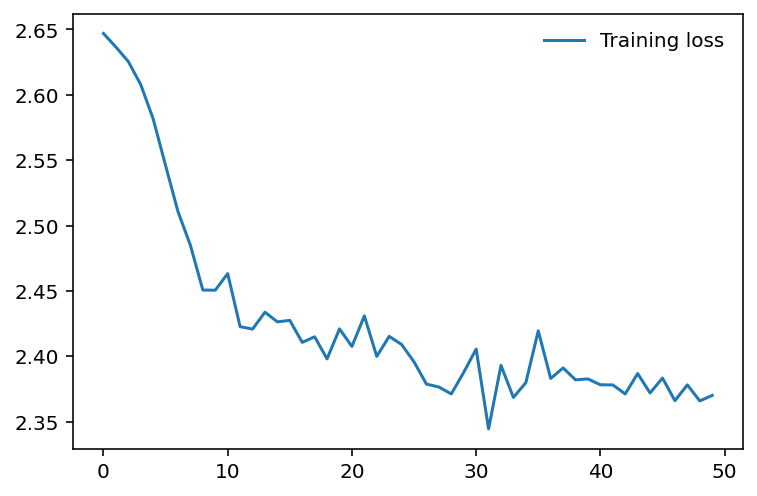

In [378]:
plt.plot(train_losses, label='Training loss')
#plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [398]:
#plt.plot(test_losses, label='Validation loss')


()

In [389]:
test_losses_1 = test_losses.copy()
test_losses_1

[tensor(2.6381, device='cuda:0'),
 tensor(2.6290, device='cuda:0'),
 tensor(2.6085, device='cuda:0'),
 tensor(2.5917, device='cuda:0'),
 tensor(2.5501, device='cuda:0'),
 tensor(2.5220, device='cuda:0'),
 tensor(2.4781, device='cuda:0'),
 tensor(2.4578, device='cuda:0'),
 tensor(2.4163, device='cuda:0'),
 tensor(2.4167, device='cuda:0'),
 tensor(2.3801, device='cuda:0'),
 tensor(2.3991, device='cuda:0'),
 tensor(2.4171, device='cuda:0'),
 tensor(2.3728, device='cuda:0'),
 tensor(2.4030, device='cuda:0'),
 tensor(2.4071, device='cuda:0'),
 tensor(2.4277, device='cuda:0'),
 tensor(2.3900, device='cuda:0'),
 tensor(2.3737, device='cuda:0'),
 tensor(2.4185, device='cuda:0'),
 tensor(2.4361, device='cuda:0'),
 tensor(2.4042, device='cuda:0'),
 tensor(2.4148, device='cuda:0'),
 tensor(2.4536, device='cuda:0'),
 tensor(2.4050, device='cuda:0'),
 tensor(2.4301, device='cuda:0'),
 tensor(2.3723, device='cuda:0'),
 tensor(2.3510, device='cuda:0'),
 tensor(2.4092, device='cuda:0'),
 tensor(2.3997

In [380]:
print("Accuracy obtained: {:.3f}%".format(accuracy/len(student_testloader)*100))


Accuracy obtained: 23.230%


In [381]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# ==============================================================================
# Modifications copyright (C) 2020 OpenMined
#
# Added type hints to functions
# Added moment values to print statements when calculating sensitivity
# ==============================================================================


"""
This script computes bounds on the privacy cost of training the
student model from noisy aggregation of labels predicted by teachers.
It should be used only after training the student (and therefore the
teachers as well). We however include the label files required to
reproduce key results from our paper (https://arxiv.org/abs/1610.05755):
the epsilon bounds for MNIST and SVHN students.
"""
import math
from typing import List, Tuple, Union

import numpy as np
import torch


def compute_q_noisy_max(counts: Union[np.ndarray, List[float]], noise_eps: float) -> float:
    """
    Returns ~ Pr[outcome != winner].
    Args:
        counts: a list of scores
        noise_eps: privacy parameter for noisy_max
    Returns:
        q: the probability that outcome is different from true winner.
    """
    # For noisy max, we only get an upper bound.
    # Pr[ j beats i*] \leq (2+gap(j,i*))/ 4 exp(gap(j,i*)
    # proof at http://mathoverflow.net/questions/66763/
    # tight-bounds-on-probability-of-sum-of-laplace-random-variables

    winner = np.argmax(counts)
    counts_normalized = noise_eps * (counts - counts[winner])

    counts_rest = np.array([counts_normalized[i] for i in range(len(counts)) if i != winner])
    q = 0.0

    for c in counts_rest:
        gap = -c
        q += (gap + 2.0) / (4.0 * math.exp(gap))

    return min(q, 1.0 - (1.0 / len(counts)))


def compute_q_noisy_max_approx(counts: List[float], noise_eps: float) -> float:
    """
    Returns ~ Pr[outcome != winner].
    Args:
        counts: a list of scores
        noise_eps: privacy parameter for noisy_max
    Returns:
        q: the probability that outcome is different from true winner.
    """
    # For noisy max, we only get an upper bound.
    # Pr[ j beats i*] \leq (2+gap(j,i*))/ 4 exp(gap(j,i*)
    # proof at http://mathoverflow.net/questions/66763/
    # tight-bounds-on-probability-of-sum-of-laplace-random-variables
    # This code uses an approximation that is faster and easier
    # to get local sensitivity bound on.

    winner = np.argmax(counts)
    counts_normalized = noise_eps * (counts - counts[winner])
    counts_rest = np.array([counts_normalized[i] for i in range(len(counts)) if i != winner])
    gap = -max(counts_rest)
    q = (len(counts) - 1) * (gap + 2.0) / (4.0 * math.exp(gap))
    return min(q, 1.0 - (1.0 / len(counts)))


def logmgf_exact(q: float, priv_eps: float, l: int) -> float:
    """
    Computes the logmgf value given q and privacy eps.
    The bound used is the min of three terms. The first term is from
    https://arxiv.org/pdf/1605.02065.pdf.
    The second term is based on the fact that when event has probability (1-q) for
    q close to zero, q can only change by exp(eps), which corresponds to a
    much smaller multiplicative change in (1-q)
    The third term comes directly from the privacy guarantee.
    Args:
        q: pr of non-optimal outcome
        priv_eps: eps parameter for DP
        l: moment to compute.
    Returns:
        Upper bound on logmgf
    """
    if q < 0.5:
        t_one = (1 - q) * math.pow((1 - q) / (1 - math.exp(priv_eps) * q), l)
        t_two = q * math.exp(priv_eps * l)
        t = t_one + t_two
        try:
            log_t = math.log(t)
        except ValueError:
            print("Got ValueError in math.log for values :" + str((q, priv_eps, l, t)))
            log_t = priv_eps * l
    else:
        log_t = priv_eps * l

    return min(0.5 * priv_eps * priv_eps * l * (l + 1), log_t, priv_eps * l)


def logmgf_from_counts(counts: Union[np.ndarray, List[float]], noise_eps: float, l: int) -> float:
    """
    ReportNoisyMax mechanism with noise_eps with 2*noise_eps-DP
    in our setting where one count can go up by one and another
    can go down by 1.
    Args:
        counts: an array of scores
        noise_eps: noise epsilon used
        l: moment to compute
    Returns:
        q: Upper bound on logmgf
    """
    q = compute_q_noisy_max(counts, noise_eps)
    return logmgf_exact(q, 2.0 * noise_eps, l)


def sens_at_k(counts: np.ndarray, noise_eps: float, l: int, k: float) -> float:
    """
    Return sensitivity at distance k.
    Args:
        counts: an array of scores
        noise_eps: noise parameter used
        l: moment whose sensitivity is being computed
        k: distance
    Returns:
        sensitivity: at distance k
    """
    counts_sorted = sorted(counts, reverse=True)

    if 0.5 * noise_eps * l > 1:
        print(f"l of {l} too large to compute sensitivity with noise epsilon {noise_eps}")
        return 0

    # Now we can assume that at k, gap remains positive
    # or we have reached the point where logmgf_exact is
    # determined by the first term and ind of q.
    if counts[0] < counts[1] + k:
        return 0

    counts_sorted[0] -= k
    counts_sorted[1] += k
    val = logmgf_from_counts(counts_sorted, noise_eps, l)

    counts_sorted[0] -= 1
    counts_sorted[1] += 1
    val_changed = logmgf_from_counts(counts_sorted, noise_eps, l)

    return val_changed - val


def smoothed_sens(counts: np.ndarray, noise_eps: float, l: int, beta: float) -> float:
    """
    Compute beta-smooth sensitivity.
    Args:
        counts: array of scores
        noise_eps: noise parameter
        l: moment of interest
        beta: smoothness parameter
    Returns:
        smooth_sensitivity: a beta smooth upper bound
    """
    k = 0
    smoothed_sensitivity = sens_at_k(counts, noise_eps, l, k)

    while k < max(counts):
        k += 1
        sensitivity_at_k = sens_at_k(counts, noise_eps, l, k)
        smoothed_sensitivity = max(smoothed_sensitivity, math.exp(-beta * k) * sensitivity_at_k)

        if sensitivity_at_k == 0.0:
            break

    return smoothed_sensitivity


def perform_analysis(
    teacher_preds: np.ndarray,
    indices: np.ndarray,
    noise_eps: float,
    delta: float = 1e-5,
    moments: int = 8,
    beta: float = 0.09,
) -> Tuple[float, float]:
    """
    Performs PATE analysis on predictions from teachers and combined predictions for student.
    Args:
        teacher_preds: a numpy array of dim (num_teachers x num_examples). Each value corresponds
            to the index of the label which a teacher gave for a specific example
        indices: a numpy array of dim (num_examples) of aggregated examples which were aggregated
            using the noisy max mechanism.
        noise_eps: the epsilon level used to create the indices
        delta: the desired level of delta
        moments: the number of moments to track (see the paper)
        beta: a smoothing parameter (see the paper)
    Returns:
        tuple: first value is the data dependent epsilon, then the data independent epsilon
    """
    num_teachers, num_examples = teacher_preds.shape
    _num_examples = indices.shape[0]
    labels = set(teacher_preds.flatten())
    num_labels = len(labels)

    if num_examples != _num_examples:
        raise ValueError("Check the shape of teacher_preds & indices.")

    counts_mat = np.zeros((num_examples, num_labels))

    for i in range(num_examples):
        for j in range(num_teachers):
            counts_mat[i, int(teacher_preds[j, i])] += 1

    l_list = 1.0 + np.array(range(moments))

    total_log_mgf_nm = np.array([0.0 for _ in l_list])
    total_ss_nm = np.array([0.0 for _ in l_list])

    for i in indices:
        total_log_mgf_nm += np.array(
            [logmgf_from_counts(counts_mat[i], noise_eps, l) for l in l_list]
        )

        total_ss_nm += np.array([smoothed_sens(counts_mat[i], noise_eps, l, beta) for l in l_list])

    # We want delta = exp(alpha - eps l).
    # Solving gives eps = (alpha - ln (delta))/l

    eps_list_nm = (total_log_mgf_nm - math.log(delta)) / l_list

    # If beta < eps / 2 ln (1/delta), then adding noise Lap(1) * 2 SS/eps
    # is eps,delta DP
    # Also if beta < eps / 2(gamma +1), then adding noise 2(gamma+1) SS eta / eps
    # where eta has density proportional to 1 / (1+|z|^gamma) is eps-DP
    # Both from Corolloary 2.4 in
    # http://www.cse.psu.edu/~ads22/pubs/NRS07/NRS07-full-draft-v1.pdf
    # Print the first one's scale

    ss_eps = 2.0 * beta * math.log(1 / delta)

    if min(eps_list_nm) == eps_list_nm[-1]:
        print(
            "Warning: May not have used enough values of l. Increase 'moments' variable and "
            "run again."
        )

    # Data independent bound, as mechanism is
    # 2*noise_eps DP.
    data_ind_log_mgf = np.array([0.0 for _ in l_list])
    data_ind_log_mgf += num_examples * np.array(
        [logmgf_exact(1.0, 2.0 * noise_eps, l) for l in l_list]
    )

    data_ind_eps_list = (data_ind_log_mgf - math.log(delta)) / l_list

    return min(eps_list_nm), min(data_ind_eps_list)


def tensors_to_literals(tensor_list: List[torch.Tensor]) -> List[Union[float, int]]:
    """
    Converts list of torch tensors to list of integers/floats. Fix for not having the functionality
    which converts list of tensors to tensors
    Args:
        tensor_list: List of torch tensors
    Returns:
        literal_list: List of floats/integers
    """
    literal_list = []

    for tensor in tensor_list:
        literal_list.append(tensor.item())

    return literal_list


def logmgf_exact_torch(q: float, priv_eps: float, l: int) -> float:
    """
    Computes the logmgf value given q and privacy eps.
    The bound used is the min of three terms. The first term is from
    https://arxiv.org/pdf/1605.02065.pdf.
    The second term is based on the fact that when event has probability (1-q) for
    q close to zero, q can only change by exp(eps), which corresponds to a
    much smaller multiplicative change in (1-q)
    The third term comes directly from the privacy guarantee.
    Args:
        q: pr of non-optimal outcome
        priv_eps: eps parameter for DP
        l: moment to compute.
    Returns:
        Upper bound on logmgf
    """
    if q < 0.5:
        t_one = (1 - q) * math.pow((1 - q) / (1 - math.exp(priv_eps) * q), l)
        t_two = q * math.exp(priv_eps * l)
        t = t_one + t_two

        try:
            log_t = math.log(t)
        except ValueError:
            print("Got ValueError in math.log for values :" + str((q, priv_eps, l, t)))
            log_t = priv_eps * l
    else:
        log_t = priv_eps * l

    return min(0.5 * priv_eps * priv_eps * l * (l + 1), log_t, priv_eps * l)


def compute_q_noisy_max_torch(
    counts: Union[List[torch.Tensor], torch.Tensor], noise_eps: float
) -> float:
    """
    Returns ~ Pr[outcome != winner].
    Args:
        counts: a list of scores
        noise_eps: privacy parameter for noisy_max
    Returns:
        q: the probability that outcome is different from true winner.
    """
    if type(counts) != torch.tensor:
        counts = torch.tensor(tensors_to_literals(counts), dtype=torch.float)

    _, winner = counts.max(0)
    counts_normalized = noise_eps * (counts.clone().detach().type(torch.float) - counts[winner])

    counts_normalized = tensors_to_literals(counts_normalized)
    counts_rest = torch.tensor(
        [counts_normalized[i] for i in range(len(counts)) if i != winner], dtype=torch.float
    )
    q = 0.0

    index = 0
    for c in counts_rest:
        gap = -c
        q += (gap + 2.0) / (4.0 * math.exp(gap))

        index += 1

    return min(q, 1.0 - (1.0 / len(counts)))


def logmgf_from_counts_torch(
    counts: Union[List[torch.Tensor], torch.Tensor], noise_eps: float, l: int
) -> float:
    """
    ReportNoisyMax mechanism with noise_eps with 2*noise_eps-DP
    in our setting where one count can go up by one and another
    can go down by 1.
    Args:
        counts: a list of scores
        noise_eps: noise parameter used
        l: moment whose sensitivity is being computed
    Returns:
        q: the probability that outcome is different from true winner
    """
    q = compute_q_noisy_max_torch(counts, noise_eps)

    return logmgf_exact_torch(q, 2.0 * noise_eps, l)


def sens_at_k_torch(counts: torch.Tensor, noise_eps: float, l: int, k: int) -> float:
    """
    Return sensitivity at distane k.
    Args:
        counts: tensor of scores
        noise_eps: noise parameter used
        l: moment whose sensitivity is being computed
        k: distance
    Returns:
        sensitivity: at distance k
    """

    counts_sorted = sorted(counts, reverse=True)

    if 0.5 * noise_eps * l > 1:
        print(f"l of {l} is too large to compute sensitivity with noise epsilon {noise_eps}")
        return 0

    if counts[0] < counts[1] + k:
        return 0

    counts_sorted[0] -= k
    counts_sorted[1] += k
    val = logmgf_from_counts_torch(counts_sorted, noise_eps, l)

    counts_sorted[0] -= 1
    counts_sorted[1] += 1
    val_changed = logmgf_from_counts_torch(counts_sorted, noise_eps, l)

    return val_changed - val


def smooth_sens_torch(counts: torch.Tensor, noise_eps: float, l: int, beta: float) -> float:
    """Compute beta-smooth sensitivity.
    Args:
        counts: tensor of scores
        noise_eps: noise parameter
        l: moment of interest
        beta: smoothness parameter
    Returns:
        smooth_sensitivity: a beta smooth upper bound
    """
    k = 0
    smoothed_sensitivity = sens_at_k_torch(counts, noise_eps, l, k)

    while k < max(counts):
        k += 1
        sensitivity_at_k = sens_at_k_torch(counts, noise_eps, l, k)
        smoothed_sensitivity = max(smoothed_sensitivity, math.exp(-beta * k) * sensitivity_at_k)

        if sensitivity_at_k == 0.0:
            break

    return smoothed_sensitivity


def perform_analysis_torch(
    preds: torch.Tensor,
    indices: torch.Tensor,
    noise_eps: float = 0.1,
    delta: float = 1e-5,
    moments: int = 8,
    beta: float = 0.09,
) -> Tuple[float, float]:
    """
    Performs PATE analysis on predictions from teachers and combined predictions for student.
    Args:
        preds: a torch tensor of dim (num_teachers x num_examples). Each value corresponds to the
            index of the label which a teacher gave for a specific example
        indices: a torch tensor of dim (num_examples) of aggregated examples which were aggregated
            using the noisy max mechanism.
        noise_eps: the epsilon level used to create the indices
        delta: the desired level of delta
        moments: the number of moments to track (see the paper)
        beta: a smoothing parameter (see the paper)
    Returns:
        tuple: first value is the data dependent epsilon, then the data independent epsilon
    """
    num_teachers, num_examples = preds.shape
    _num_examples = indices.shape[0]

    # Check that preds is shape (teachers x examples)
    if num_examples != _num_examples:
        raise ValueError("Check the shape of preds & indices.")

    labels = list(preds.flatten())
    labels = {tensor.item() for tensor in labels}
    num_labels = len(labels)

    counts_mat = torch.zeros(num_examples, num_labels, dtype=torch.float32)

    # Count number of teacher predictions of each label for each example
    for i in range(num_examples):
        for j in range(num_teachers):
            counts_mat[i, int(preds[j, i])] += 1

    l_list = 1 + torch.tensor(range(moments), dtype=torch.float)

    total_log_mgf_nm = torch.tensor([0.0 for _ in l_list], dtype=torch.float)
    total_ss_nm = torch.tensor([0.0 for _ in l_list], dtype=torch.float)

    for i in indices:
        total_log_mgf_nm += torch.tensor(
            [logmgf_from_counts_torch(counts_mat[i].clone(), noise_eps, l) for l in l_list]
        )

        total_ss_nm += torch.tensor(
            [smooth_sens_torch(counts_mat[i].clone(), noise_eps, l, beta) for l in l_list],
            dtype=torch.float,
        )

    eps_list_nm = (total_log_mgf_nm - math.log(delta)) / l_list
    ss_eps = 2.0 * beta * math.log(1 / delta)

    if min(eps_list_nm) == eps_list_nm[-1]:
        print(
            "Warning: May not have used enough values of l. Increase 'moments' variable "
            "and run again."
        )

    # Computer epsilon when not taking teacher quorum into account
    data_ind_log_mgf = torch.tensor([0.0 for _ in l_list])
    data_ind_log_mgf += num_examples * torch.tensor(
        tensors_to_literals([logmgf_exact_torch(1.0, 2.0 * noise_eps, l) for l in l_list])
    )

    data_ind_eps_list = (data_ind_log_mgf - math.log(delta)) / l_list

    return min(eps_list_nm), min(data_ind_eps_list)

In [382]:
data_dep_eps, data_ind_eps = perform_analysis(teacher_preds=preds, indices=student_labels, noise_eps=epsilon, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps) 
print("Data Dependent Epsilon:", data_dep_eps) #Is the Epsilon value obtained by looking at how much teacher agree with each other

Data Independent Epsilon: 161.51292546497024
Data Dependent Epsilon: 161.51292546497024
